In [1]:
import time
import ray
ray.init(lru_evict=True)

2020-04-04 14:08:31,879	INFO resource_spec.py:212 -- Starting Ray with 3.27 GiB memory available for workers and up to 1.64 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-04 14:08:32,414	INFO services.py:1148 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '10.0.0.118',
 'redis_address': '10.0.0.118:49184',
 'object_store_address': '/tmp/ray/session_2020-04-04_14-08-31_865504_2140/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-04-04_14-08-31_865504_2140/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-04-04_14-08-31_865504_2140'}

In [2]:
@ray.remote(num_cpus=1)
def caesar_str_enc(plaintext, K):
    ciphertext=""
    for ch in plaintext:
        if ord(ch) == 32:
            encch = ch
        else:
            encch = (ord(ch)-97+K) < 25 and chr(((ord(ch)-97+K)%26)+97) or chr(((ord(ch)-97+K-26)%26)+97)
        ciphertext = ciphertext + encch 
    return ciphertext

In [3]:
caesar_single_core_list = []

def caesar_single_core(length_list):
    for i in length_list:
        plaintext = "a"*i
        key = 15
        
        start_time = time.time()
        full_at_a_time = caesar_str_enc.remote(plaintext, key)
        full_at_a_time = ray.get(full_at_a_time)
        caesar_single_core_list.append(time.time() - start_time)

In [4]:
caesar_double_core_list = []

def caesar_double_core(length_list):
    for i in length_list:
        plaintext = "a"*i
        key = 15
        
        first_half = plaintext[:len(plaintext)//2]
        second_half = plaintext[len(plaintext)//2:]
        
        start_time = time.time()
        first_half = caesar_str_enc.remote(first_half, key)
        second_half = caesar_str_enc.remote(second_half, key)
        first_half = ray.get(first_half)
        second_half = ray.get(second_half)
        caesar_double_core_list.append(time.time() - start_time)

In [5]:
length_list = [100, 1000, 10000, 100000, 1000000, 10000000, 100000000]
caesar_single_core(length_list)
caesar_double_core(length_list)

In [6]:
import numpy as np
import pandas as pd

In [7]:
data = []
finaldata = []
for i, j, k in zip(length_list, caesar_single_core_list, caesar_double_core_list):
    data.append([i, j, k])

data = np.array(data)
pd.DataFrame(data, columns=['Plaintext length','Single core', 'Double core'])

,Plaintext length,Single core,Double core
0,100.0,3.095938,0.003352
1,1000.0,0.003419,0.002430
2,10000.0,0.012301,0.005229
3,100000.0,0.079542,0.032946
4,1000000.0,0.741734,0.331617
5,10000000.0,6.287088,3.148533
6,100000000.0,60.941293,37.111739


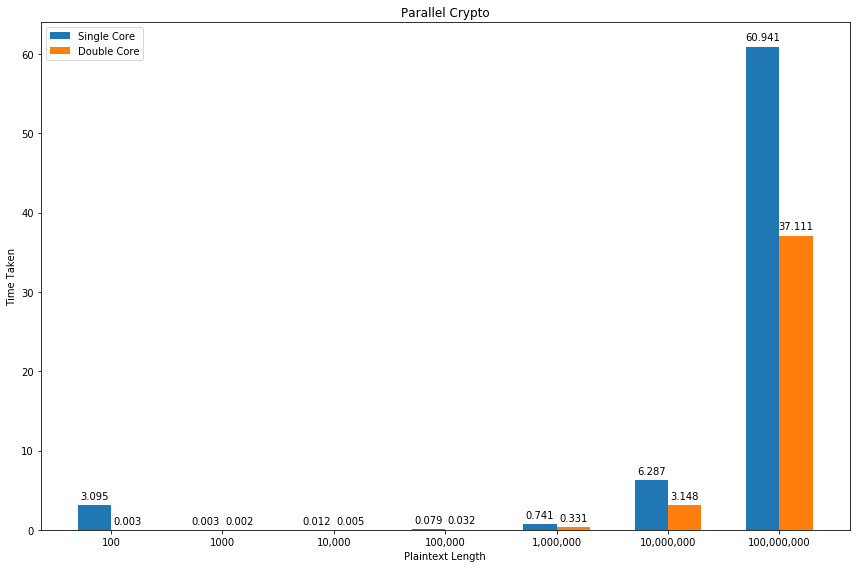

In [26]:
import matplotlib
import matplotlib.pyplot as plt
import decimal

labels = ["100", "1000", "10,000", "100,000", "1,000,000", "10,000,000", "100,000,000"]

decimal.getcontext().rounding = decimal.ROUND_DOWN
caesar_single_core_list_1 = [decimal.Decimal(i) for i in caesar_single_core_list]
caesar_double_core_list_1 = [decimal.Decimal(i) for i in caesar_double_core_list]

caesar_single_core_list_1 = [float(round(i,3)) for i in caesar_single_core_list_1]
caesar_double_core_list_1 = [float(round(i,3)) for i in caesar_double_core_list_1]

x = np.arange(len(labels))
width = 0.30

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, caesar_single_core_list_1, width, label='Single Core')
rects2 = ax.bar(x + width/2, caesar_double_core_list_1, width, label='Double Core')

ax.set_ylabel('Time Taken')
ax.set_xlabel('Plaintext Length')
ax.set_title('Parallel Crypto')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4), 
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()

plt.show()